In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Package

In [ ]:
import os
import sys
import cv2
import time
import scipy as sp
import numpy as np
import random as rn
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import initializers
from keras import regularizers
from keras import constraints
from keras import backend as K
from keras.activations import elu
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Layer, InputSpec
from keras.utils.generic_utils import get_custom_objects
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import f1_score
from sklearn.model_selection import ShuffleSplit

# 參數設定

In [ ]:
# 路徑
path2file = '/content/drive/MyDrive/APTOS_2019/'
path2data = '/content/drive/MyDrive/APTOS_2019/data/'
path2label = path2data + "train.csv"
path2image = path2data + "train_images/"

In [ ]:
# 圖片大小
IMG_WIDTH_B3 = 300
IMG_HEIGHT_B3 = 300
IMG_WIDTH_B5 = 456
IMG_HEIGHT_B5 = 456
CHANNELS = 3

# Model
BATCH_SIZE = 4
epochs=15
learning_rate=0.00005

# Best Model
SAVED_MODEL_NAME_B3 = 'effnet_modelB3.h5'
SAVED_MODEL_NAME_B5 = 'effnet_modelB5.h5'
# 記初始時間
t_start = time.time()

#Load Data


In [ ]:
train_df=pd.read_csv(path2label)
train_df['id_code'] = train_df['id_code'] + ".png"
train_df.head()

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


In [ ]:
sss = ShuffleSplit(n_splits=1, test_size=0.15, random_state=0)

indices=range(len(train_df))

for tra_index, val_index in sss.split(indices):
    print(len(tra_index))
    print("-"*10)
    print(len(val_index))


3112
----------
550


In [ ]:
tra_df=train_df.loc[tra_index]
print(tra_df)
val_df=train_df.loc[val_index]
print(val_df)

               id_code  diagnosis
582   291f581d365e.png          0
1560  6d6fcf49e515.png          0
1448  65dda202653d.png          0
159   0c2e2369dfff.png          2
1989  8bbd7835e9aa.png          1
...                ...        ...
835   3c326543fff6.png          0
3264  e2a47a74e6e1.png          2
1653  7526cf435753.png          0
2607  b549af91bd30.png          0
2732  bd375ba756b1.png          0

[3112 rows x 2 columns]
               id_code  diagnosis
2596  b460ca9fa26f.png          0
1548  6cee2e148520.png          0
2912  ca6842bfcbc9.png          1
1544  6cbc3dad809c.png          2
2438  a9bc2f892cb3.png          0
...                ...        ...
566   2821998fc002.png          0
1332  5ca73d28f17f.png          0
2963  cd5714db652d.png          1
638   2cfe8703f265.png          0
1888  851e40a21f81.png          0

[550 rows x 2 columns]


# 指標 (F1 Score)

In [ ]:
def get_preds_and_labels(model, generator):

    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)

    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()


class Metrics_B3(Callback):
    def on_train_begin(self, logs={}):

        self.val_f1_score = []

    def on_epoch_end(self, epoch, logs={}):

        y_pred, labels = get_preds_and_labels(model_B3, val_generator_B3)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)

        _val_f1_score = f1_score(labels, y_pred, average='macro')
        self.val_f1_score.append(_val_f1_score)
        print(f" - val_f1_score: {round(_val_f1_score, 4)}")
        if _val_f1_score == max(self.val_f1_score):
            print("Validation F1 score has improved. Saving model.")
            self.model.save(path2file+SAVED_MODEL_NAME_B3)
        return

class Metrics_B5(Callback):
    def on_train_begin(self, logs={}):

        self.val_f1_score = []

    def on_epoch_end(self, epoch, logs={}):

        y_pred, labels = get_preds_and_labels(model_B5, val_generator_B5)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)

        _val_f1_score = f1_score(labels, y_pred, average='macro')
        self.val_f1_score.append(_val_f1_score)
        print(f" - val_f1_score: {round(_val_f1_score, 4)}")
        if _val_f1_score == max(self.val_f1_score):
            print("Validation F1 score has improved. Saving model.")
            self.model.save(path2file+SAVED_MODEL_NAME_B5)
        return

# 測試前處理以前的data

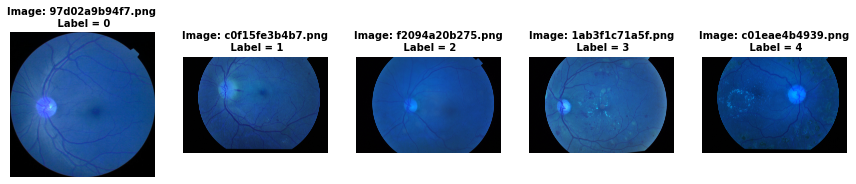

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{path2image}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

# Preprocess (變灰、切黑色、Resize)

In [ ]:
def crop_image_from_gray(img, tol=7):

    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [ ]:
def preprocess_image_B3(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH_B3, IMG_HEIGHT_B3))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image


In [ ]:
def preprocess_image_B5(image, sigmaX=10):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH_B5, IMG_HEIGHT_B5))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image


#測試前處理後的data


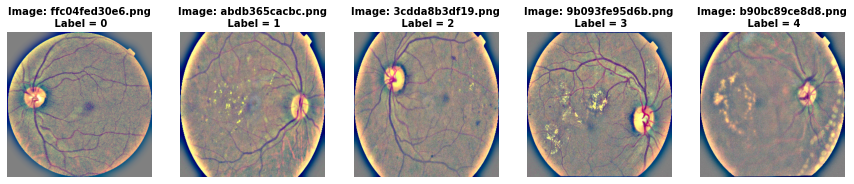

In [ ]:
# model_B3
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image_B3(cv2.imread(f"{path2image}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

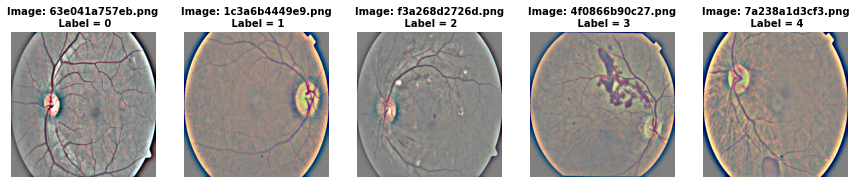

In [ ]:
# model_B5
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image_B5(cv2.imread(f"{path2image}{image_name}"))
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

# 創造資料的generator

In [ ]:
# Add Image augmentation to our generator
train_datagen_B3 = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7,1.3],
                                   preprocessing_function=preprocess_image_B3, 
                                   rescale=1 / 128.) 
train_datagen_B5 = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.7,1.3],
                                   preprocessing_function=preprocess_image_B5, 
                                   rescale=1 / 128.) 
val_datagen_B3 = ImageDataGenerator(preprocessing_function=preprocess_image_B3, 
                                   rescale=1 / 128.) 
val_datagen_B5 = ImageDataGenerator(preprocessing_function=preprocess_image_B5, 
                                   rescale=1 / 128.) 

# Use the dataframe to define train and validation generators
train_generator_B3 = train_datagen_B3.flow_from_dataframe(tra_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = path2image,
                                                    target_size=(IMG_WIDTH_B3, IMG_HEIGHT_B3),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other')

val_generator_B3 = val_datagen_B3.flow_from_dataframe(val_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = path2image,
                                                  target_size=(IMG_WIDTH_B3, IMG_HEIGHT_B3),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other')

train_generator_B5 = train_datagen_B5.flow_from_dataframe(tra_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = path2image,
                                                    target_size=(IMG_WIDTH_B5, IMG_HEIGHT_B5),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other')

val_generator_B5 = val_datagen_B5.flow_from_dataframe(val_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = path2image,
                                                  target_size=(IMG_WIDTH_B5, IMG_HEIGHT_B5),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other')

--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 3113 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 549 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 3113 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.7/logging/__init__.py", line 1025, in emit
    msg = self.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 869, in format
    return fmt.format(record)
  File "/usr/lib/python3.7/logging/__init__.py", line 608, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.7/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/pytho

Found 549 validated image filenames.


# Load pre-train model

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
effnet_B3 = EfficientNetB3(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_WIDTH_B3, IMG_HEIGHT_B3, CHANNELS))

In [ ]:
from tensorflow.keras.applications import EfficientNetB5
effnet_B5 = EfficientNetB5(weights='imagenet',
                        include_top=False,
                        input_shape=(IMG_WIDTH_B5, IMG_HEIGHT_B5, CHANNELS))

# Build model

In [ ]:
def build_model_B3():
    model = Sequential()
    model.add(effnet_B3)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model_B3 = build_model_B3()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 10, 10, 1536)     10783535  
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1536)              0         
                                                                 
 dense_7 (Dense)             (None, 5)                 7685      
                                                                 
 dense_8 (Dense)             (None, 1)                 6         
                                                                 
Total params: 10,791,226
Trainable params: 10,703,923
Non-trainable params: 87,303
_____________________________________

In [ ]:
def build_model_B5():

    model = Sequential()
    model.add(effnet_B5)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize model
model_B5 = build_model_B5()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_5   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 5)                 10245     
                                                                 
 dense_10 (Dense)            (None, 1)                 6         
                                                                 
Total params: 28,523,778
Trainable params: 28,351,035
Non-trainable params: 172,743
____________________________________

# Train Data!

In [ ]:
# Monitor MSE to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=8)
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.5, 
                        patience=4, 
                        verbose=1, 
                        mode='auto',
                        epsilon=0.0001)

In [ ]:
# Begin training for model_B3
f1_score_metrics_B3 = Metrics_B3()
model_B3.fit(train_generator_B3,
                    steps_per_epoch=train_generator_B3.samples // BATCH_SIZE,
                    epochs=epochs,
                    validation_data=val_generator_B3,
                    validation_steps = val_generator_B3.samples // BATCH_SIZE,
                    callbacks=[f1_score_metrics_B3, es, rlr])

In [ ]:
# Begin training for model_B5
f1_score_metrics_B5 = Metrics_B5()
model_B5.fit(train_generator_B5,
                    steps_per_epoch=train_generator_B5.samples // BATCH_SIZE,
                    epochs=epochs,
                    validation_data=val_generator_B5,
                    validation_steps = val_generator_B5.samples // BATCH_SIZE,
                    callbacks=[f1_score_metrics_B5, es, rlr])

# 畫圖

In [ ]:
history_df = pd.DataFrame(model_B3.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In [ ]:
history_df = pd.DataFrame(model_B5.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE)", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

# Evaluation

In [ ]:
model_B3.load_weights(path2file+SAVED_MODEL_NAME_B3)

# Calculate F1 on B3 train set
y_train_preds, train_labels = get_preds_and_labels(model_B3, train_generator_B3)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)
# Calculate score
train_f1score_B3 = f1_score(y_train_preds, train_labels,  average='macro')
train_kappascore_B3 = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate F1 on B3 validation set
y_val_preds, val_labels = get_preds_and_labels(model_B3, val_generator_B3)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)
# Calculate score
val_f1score_B3 = f1_score(y_val_preds, val_labels, average='macro')
val_kappascore_B3 = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

print(f"The Training F1 Score on B3 is: {round(train_f1score_B3, 5)}")
print(f"The Training Kappa Score on B3 is: {round(train_kappascore_B3, 5)}")
print(f"The Validation F1 Score on B3 is: {round(val_f1score_B3, 5)}")
print(f"The Validation Kappa Score on B3 is: {round(val_kappascore_B3, 5)}")

In [ ]:
model_B5.load_weights(path2file+SAVED_MODEL_NAME_B5)

# Calculate F1 on B5 train set
y_train_preds, train_labels = get_preds_and_labels(model_B5, train_generator_B5)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)
# Calculate score
train_f1score_B5 = f1_score(y_train_preds, train_labels,  average='macro')
train_kappascore_B5 = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate F1 on B3 validation set
y_val_preds, val_labels = get_preds_and_labels(model_B5, val_generator_B5)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)
# Calculate score
val_f1score_B5 = f1_score(y_val_preds, val_labels, average='macro')
val_kappascore_B5 = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

print(f"The Training F1 Score on B5 is: {round(train_f1score_B5, 5)}")
print(f"The Training Kappa Score on B5 is: {round(train_kappascore_B5, 5)}")
print(f"The Validation F1 Score on B5 is: {round(val_f1score_B5, 5)}")
print(f"The Validation Kappa Score on B5 is: {round(val_kappascore_B5, 5)}")

# Calculate run-time


In [ ]:
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, int(total_time*60)))